# Project: Wrangling and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Data Gathering</a></li>
<li><a href="#assessing">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#resources">Resources</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Descriptions

#### WeRateDogs enhanched twitter archive data

This dataset is provided by Udacity and is actually a subset of the 5000+ tweets from the WeRateDogs Twitter archive that have been filtered for tweets with ratings only.

|        **Features**        |                                                             **Description**                                                            |
|:--------------------------:|:--------------------------------------------------------------------------------------------------------------------------------------:|
|          tweet_id          |                                                        Unique id for each tweet                                                        |
|    in_reply_to_status_id   |                                               The tweet id for the tweet the reply is to                                               |
|     in_reply_to_user_id    |                                                    The user id that the reply is to                                                    |
|          timestamp         |                                                     Date and time tweet was posted                                                     |
|           source           |                                                      Source tweet was posted from                                                      |
|            text            |                                                        Text content of the tweet                                                       |
|     retweeted_status_id    |                                                   ID of the tweet that was retweeted                                                   |
|  retweeted_status_user_id  |                                                   User ID of user from original tweet                                                  |
| retweeted_status_timestamp |                                                    Date and time retweet was posted                                                    |
|        expanded_urls       |               URLs for links to media inside in the tweet (this can be video, photo, urls to other tweets, or other URLs)              |
|      rating_numerator      | Rating for dog (Can be higher than denominator per this [unique rating system](https://knowyourmeme.com/memes/theyre-good-dogs-brent)) |
|     rating_denominator     |                                Top of scale for rating of dog (although can be lower than the numerator)                               |
|            name            |                                                             Name of the dog                                                            |
|            doggo           |                              A big pupper, usually older. A pupper that appears to have its life in order.                             |
|           floofer          |                        Any dog really. However, this label is commonly given to dogs with seemingly excess fur.                        |
|           pupper           |                                                     A small doggo, usually younger.                                                    |
|            puppo           |                  A transitional phase between pupper and doggo. Easily understood as the dog equivalent of a teenager.                 |

#### Tweet image prediction data

This dataset is the result of running every image from the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs. This dataset gives the top three predictions only.

| **Features** |                                                         **Description**                                                        |
|:------------:|:------------------------------------------------------------------------------------------------------------------------------:|
|   tweet_id   |                                                    Unique id for each tweet                                                    |
|    jpg_url   |                                                        URL for the image                                                       |
|    img_num   | The image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). |
|      p1      |                                    The algorithm's #1 prediction for the image in the tweet                                    |
|    p1_conf   |                                       How confident the algorithm is in its #1 prediction                                      |
|    p1_dog    |                                       Whether or not the #1 prediction is a breed of dog                                       |
|      p2      |                                          The algorithm's second most likely prediction                                         |
|    p2_conf   |                                       How confident the algorithm is in its #2 prediction                                      |
|    p2_dog    |                                       Whether or not the #2 prediction is a breed of dog                                       |
|      p3      |                                          The algorithm's third most likely prediction                                          |
|    p3_conf   |                                       How confident the algorithm is in its #3 prediction                                      |
|    p3_dog    |                                       Whether or not the #3 prediction is a breed of dog                                       |

#### Twitter API results

This is the resulting data from the Twitter API code provided by Udacity which shows the retweet count and favorite count for each tweet from the WeRateDogs enhanced Twitter archive dataset.

|  **Features**  |                **Description**                |
|:--------------:|:---------------------------------------------:|
|    tweet_id    |            Unique id for each tweet           |
|  retweet_count |            Total number of retweets           |
| favorite_count | Total number of times the tweet was favorited |

### Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import os
import requests
import lxml
from dotenv import load_dotenv
from PIL import Image
import urllib.request
from io import BytesIO

%matplotlib inline

Set options for showing dataframes

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

<a id='gathering'></a>
## Data Gathering

<ul>
<li><a href="#twitter_archive">WeRateDogs Twitter archive data</a></li>
<li><a href="#img_predictions">Tweet image prediction data</a></li>
<li><a href="#tweet_json">Twitter API data</a></li>
</ul>

<a id='twitter_archive'></a>
### Read in the WeRateDogs Twitter archive data downloaded directly from Udacity

In [3]:
twitter_archive = pd.read_csv('./data/twitter-archive-enhanced.csv')

<a id='img_predictions'></a>
### Use the Requests library to download the tweet image prediction data

#### Creating functions to be used for creating folders, files, and downloading data using the Requests library

In [4]:
def get_data_content(url):
    """
    Return the content of the response of provided url

    This script requires that `requests` be installed within the Python
    environment you are running this script in.

    Parameter
    -----------
    url : str

    Returns
    ----------
    byte
        Response from url as bytes
    """
    
    response = requests.get(url)
    return response.content

def create_folder(folder_name):
    """
    Creates a folder in immediate path if the folder name does not already exist

    This script requires that `os` be installed within the Python environment you 
    are running this script in.

    Parameter
    -----------
    folder_name : str
    """
    
    # Checks directory for folder, folder_name
    if not os.path.exists(folder_name):
        os.makedirs(folder_name) # If folder_name was not found, makes new folder, folder_name

def create_file(url, folder_name):
    """
    Creates a file with the contents from `get_data_content` in folder if the file 
    name does not already exist

    This script requires that `os` be installed within the Python environment you 
    are running this script in.

    Parameters
    -----------
    url : str
    folder_name : str
    """
    
    file_name = url.split('/')[-1] # Splits the url string at the last / and keeps the text to the right of it
    # If file_name does not exists inside folder_name, save contents of response
    # response.content is stored as bytes so mode argument is set to 'wb' for write binary
    with open(os.path.join(folder_name,
                           file_name),
                           mode='wb') as file:
        if not os.path.exists(file_name):
            file.write(get_data_content(url))

def create_data_file(url, folder_name):
    """
    Create file with contents from the response of a URL inside a folder

    Parameters
    -----------
    url : str
    folder_name : str    
    """
    
    create_folder(folder_name)
    create_file(url, folder_name)

In [5]:
create_data_file('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv',
                 'data')

In [6]:
img_predictions = pd.read_csv('./data/image-predictions.tsv', delimiter='\t')

<a id='tweet_json'></a>
### Use the Tweepy library to query additional data via the Twitter API

Below is the code provided by Udacity to students that are unable to use the API (which will be all students now that Twitter has changed their API access). 

**Please note:**
> Twitter no longer allows v1 API access. The free plan for v2 does not include lookup of tweets. The basic plan for v2 can retrieve up to 10,000 tweets per month at a rate limit of 15 requests/15 minutes. However, the basic plan costs $100/month
> 
> I had already created a dotenv file to store my API credentials to keep them hidden
> 
> The cell below is in Raw format to avoid it being run since the code assumes using v1.1 of Twitter's API and I was only able to get v2 credentials

Since I am unable to use the Twitter API to gather the data I need I will be using the resulting data of the code above as provided by Udacity.

> I will be doing this following the same method to get the image-predictions.tsv data

In [7]:
create_data_file('https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt',
                 'data')

In [8]:
df_list = [] # Creates empty list to build DataFrame later
with open('./data/tweet-json.txt', encoding='utf-8') as file:
    for line in file:
        tweet = json.loads(line) # Store line as JSON format to make the process of accessing data easier than using slice method
        tweet_id = tweet['id_str'] # Get tweet id as string
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        # Add dict to list to use for creating a DataFrame
        df_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})

# Create DataFrame using list created from file
tweet_json = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

<a id='assessing'></a>
## Assessing Data

<ul>
<li><a href="#archive">Assessing twitter_archive</a></li>
<li><a href="#predictions">Assessing img_predictions</a></li>
<li><a href="#json">Assessing tweet_json</a></li>
<li><a href="#quality">Quality Issues</a></li>
<li><a href="#Tidiness">Tidiness Issues</a></li>
</ul>

In [9]:
# Reusing my own function that I used for the Investigate_a_dataset project from earlier in this nanodegree
# I did update the docstring and ensured it was code that was used more than once
def check_for_dupes(data, col):
    """
    Checks for duplicate values in each column of a dataset (dupe or dupes)
    Returns column name, number of duplicated values, and list of duplicated values with frequency of each value (if applicable)

    Parameter
    -----------
    data : DataFrame
    col : Series from DataFrame
    """
    
    dupe_count = data[col].duplicated().sum()
    if dupe_count == 0:
        return f'{col} has {dupe_count} dupes\n'
    elif dupe_count == 1:
        return f'{col} has {dupe_count} dupe:\n{data[col].value_counts()}\n'
    else:
        return f'{col} has {dupe_count} dupes:\n{data[col].value_counts()}\n'

<a id='archive'></a>
### Assessing `twitter_archive`

#### Visual assessment

In [10]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,NaN,NaN,NaN,NaN,NaN
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,NaN,NaN,NaN,NaN
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,NaN,NaN,NaN,NaN
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,NaN,NaN,NaN,NaN


##### Visual Assessment notes:

* Names are missing
* Names are 'a'
* Rows are missing a classification for one of doggo, floofer, pupper, or puppo
* expanded_urls have multiple URLs separated by commas, some of the URLs are for photos while others are for videos or other links.

#### Programmatic Assessment

In [11]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        1611 non-null   object 
 13  doggo                       97 no

* 78 rows are replies (will need to ensure these are not updates to ratings)
* 181 rows are retweets (which for tweets can be considered duplicated data since it is a repost of an original tweet) and should not be included in the analysis of this dataset
* 59 rows are missing values in the exapnded_urls column
* Name is missing value for 745 rows
* Doggo, floofer, pupper, and puppo are not completed for a majority of the records
* in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are float and should be string
* timestamp and retweeted_status_timestamp are object and should be string

In [12]:
# Count of duplicated rows
twitter_archive.duplicated().sum()

0

In [13]:
# Print out the duplicate values for each column in the data set
for col in twitter_archive.columns:
    print(check_for_dupes(twitter_archive, col), '\n', '--------------------------------------------', '\n')

tweet_id has 0 dupes
 
 -------------------------------------------- 

in_reply_to_status_id has 2278 dupes:
in_reply_to_status_id
6.671522e+17    2
8.862664e+17    1
6.920419e+17    1
6.827884e+17    1
6.842229e+17    1
6.844811e+17    1
6.849598e+17    1
6.855479e+17    1
6.860340e+17    1
6.903413e+17    1
6.924173e+17    1
6.780211e+17    1
6.935722e+17    1
6.936422e+17    1
6.706684e+17    1
6.753494e+17    1
6.964887e+17    1
7.030419e+17    1
7.044857e+17    1
6.813394e+17    1
6.765883e+17    1
7.079801e+17    1
6.757073e+17    1
6.689207e+17    1
6.678065e+17    1
6.693544e+17    1
6.715449e+17    1
6.715610e+17    1
6.737159e+17    1
6.658147e+17    1
6.744689e+17    1
6.747400e+17    1
6.747522e+17    1
6.717299e+17    1
6.747934e+17    1
6.749998e+17    1
6.754971e+17    1
6.758457e+17    1
7.032559e+17    1
7.291135e+17    1
8.816070e+17    1
8.320875e+17    1
8.380855e+17    1
8.381455e+17    1
8.406983e+17    1
7.590995e+17    1
8.476062e+17    1
8.482121e+17    1
8.503

tweet_id values are all unique

expanded_urls has 137 dupes which might mean they are duplicated by retweets and/or replies. Although this number is lower than the number of tweets with retweets. This will require further investigation and will also require cleaning/transforming the data.

In [14]:
# Find all the unique values in each column
for col in twitter_archive.columns:
    print(f'{col.upper()} has {twitter_archive[col].nunique()} unique values:\n  {twitter_archive[col].sort_values().unique()} \n\n ---------------------------------------------------------\n')

TWEET_ID has 2356 unique values:
  [666020888022790149 666029285002620928 666033412701032449 ...
 891815181378084864 892177421306343426 892420643555336193] 

 ---------------------------------------------------------

IN_REPLY_TO_STATUS_ID has 77 unique values:
  [6.65814697e+17 6.67065536e+17 6.67152164e+17 6.67806455e+17
 6.68920717e+17 6.69354383e+17 6.70668383e+17 6.71544874e+17
 6.71561002e+17 6.71729907e+17 6.73715862e+17 6.74468881e+17
 6.74739953e+17 6.74752233e+17 6.74793399e+17 6.74999808e+17
 6.75349384e+17 6.75497103e+17 6.75707330e+17 6.75845657e+17
 6.76588346e+17 6.78021116e+17 6.81339449e+17 6.82788442e+17
 6.84222868e+17 6.84481075e+17 6.84959799e+17 6.85547936e+17
 6.86034025e+17 6.90341254e+17 6.91416866e+17 6.92041935e+17
 6.92417313e+17 6.93572216e+17 6.93642232e+17 6.96488711e+17
 7.03041950e+17 7.03255936e+17 7.04485745e+17 7.07980066e+17
 7.29113531e+17 7.33109485e+17 7.38411920e+17 7.46885919e+17
 7.47648654e+17 7.50180499e+17 7.59099524e+17 7.63865175e+17
 7.6

rating_numerator has some outliers as values and will need to be researched.

rating_denominator should normally be 10 but has some other values as well. This will require further research.

The list of names that appear to be incorrect and will need to be cleaned:

<ul>
    <li>'a'</li>
    <li>'actually'</li>
    <li>'all'</li>
    <li>'an'</li>
    <li>'by'</li>
    <li>'getting'</li>
    <li>'his'</li>
    <li>'incredibly'</li>
    <li>'infuriating'</li>
    <li>'just'</li>
    <li>'life'</li>
    <li>'light'</li>
    <li>'mad'</li>
    <li>'my'</li>
    <li>'not'</li>
    <li>'officially'</li>
    <li>'old'</li>
    <li>'one'</li>
    <li>'quite'</li>
    <li>'space'</li>
    <li>'such'</li>
    <li>'the'</li>
    <li>'this'</li>
    <li>'unacceptable'</li>
    <li>'very'</li>
</ul>

In [15]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [16]:
# Show all records that do not have expanded_urls
twitter_archive[twitter_archive['expanded_urls'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,NaN,NaN,NaN,NaN,NaN
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,NaN
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,NaN,NaN,NaN,NaN,NaN
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,NaN,NaN,NaN,NaN,NaN
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,NaN,NaN,NaN,NaN,NaN
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,NaN,NaN,NaN,NaN,NaN


Most of the tweets that don't have expanded_urls are either retweets or replies which make sense since retweets are just reposting a previous tweet and replies are usually just text tweets in response to another tweet or reply.

However, there are a few original tweets that have ratings but are not for a dog image. 

tweet_id [696518437233913856](https://twitter.com/dog_rates/status/696518437233913856) is just a text tweet.

tweet_id [785515384317313025](https://twitter.com/dog_rates/status/785515384317313025) is just a text tweet.

tweet_id [828361771580813312](https://twitter.com/dog_rates/status/828361771580813312) is just a text tweet.

In [17]:
# Show all records that are retweets
twitter_archive[~twitter_archive['retweeted_status_id'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,NaN,NaN,NaN,NaN
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,NaN,NaN,NaN,NaN,NaN
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,NaN,NaN,NaN,NaN
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,NaN,NaN,NaN,NaN
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,NaN,NaN,NaN,NaN
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,NaN,NaN,NaN,NaN
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,NaN,NaN,NaN,pupper,NaN
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iP

In [18]:
# Show all records that are replies
twitter_archive[~twitter_archive['in_reply_to_status_id'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,NaN,NaN,NaN,NaN,NaN
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,NaN
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,NaN,NaN,NaN,NaN,NaN
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,NaN,NaN,NaN,NaN,NaN
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,NaN,NaN,NaN,NaN,NaN
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,NaN,NaN,NaN,NaN,NaN


For tweet_id [886267009285017600](https://twitter.com/dog_rates/status/886267009285017600) this is a reply to a picture posted. This is not an original tweet by WeRateDogs.

For tweet_id [881633300179243008](https://twitter.com/dog_rates/status/881633300179243008) this is also a reply to tweet by another user. This is not an original tweet by WeRateDogs.

For tweet_id [840698636975636481](https://twitter.com/dog_rates/status/840698636975636481) this is a reply within a thread for tweet_id [840696689258311684](https://twitter.com/dog_rates/status/840696689258311684) and that original tweet, even though it is by WeRateDogs, is not a rating for a dog.

Another find in the dataset is that some replies are pupgrades/pupdates to original ratings. For instance, tweet_id [856526610513747968](https://twitter.com/dog_rates/status/856526610513747968) is a pupgrade but also includes a new picture of the same dog in the [original tweet](https://twitter.com/dog_rates/status/855818117272018944).

In [19]:
# Show info for records that are replies
twitter_archive[~twitter_archive['in_reply_to_status_id'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 30 to 2298
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    78 non-null     int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   78 non-null     object 
 4   source                      78 non-null     object 
 5   text                        78 non-null     object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               23 non-null     object 
 10  rating_numerator            78 non-null     int64  
 11  rating_denominator          78 non-null     int64  
 12  name                        1 non-null      object 
 13  doggo                       4 non-null 

23 of the 78 replies have expanded_urls

In [20]:
# Show all records that are replies
replies = twitter_archive[~twitter_archive['in_reply_to_status_id'].isna()]
# Show all replies that include pupgraded or pupdate in the tweet text
replies[replies['text'].str.contains('pupgraded|pupdate', case=False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,NaN,NaN,NaN,NaN,NaN
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,NaN,NaN,NaN,NaN,NaN
228,848213670039564288,8.482121e+17,4.196984e+09,2017-04-01 16:41:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Jerry just apuppologized to me. He said there was no ill-intent to the slippage. I overreacted I admit. Pupgraded to an 11/10 would pet,NaN,NaN,NaN,NaN,11,10,NaN,NaN,NaN,NaN,NaN
234,847617282490613760,8.476062e+17,4.196984e+09,2017-03-31 01:11:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",.@breaannanicolee PUPDATE: Cannon has a heart on his nose. Pupgraded to a 13/10,NaN,NaN,NaN,NaN,13,10,NaN,NaN,NaN,NaN,NaN
251,844979544864018432,7.590995e+17,4.196984e+09,2017-03-23 18:29:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby https://t.co/a5OaJeRl9B",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1",13,10,NaN,NaN,NaN,NaN,NaN
498,813130366689148928,8.131273e+17,4.196984e+09,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been informed by multiple sources that this is actually a dog elf who's tired from helping Santa all night. Pupgraded to 12/10,NaN,NaN,NaN,NaN,12,10,NaN,NaN,NaN,NaN,NaN
513,811647686436880384,8.116272e+17,4.196984e+09,2016-12-21 19:01:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",PUPDATE: I've been informed that Augie was actually bringing his family these flowers when he tripped. Very good boy. Pupgraded to 11/10,NaN,NaN,NaN,NaN,11,10,NaN,NaN,NaN,NaN,NaN
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,NaN,NaN,NaN,NaN,NaN
1127,729838605770891264,7.291135e+17,4.196984e+09,2016-05-10 01:00:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Challenge completed"" \n(pupgraded to 12/10) https://t.co/85dTK7XCXB",NaN,NaN,NaN,https://twitter.com/dog_rates/status/729838605770891264/video/1,12,10,NaN,NaN,NaN,NaN,NaN
1474,693644216740769793,6.936422e+17,4.196984e+09,2016-01-31 03:57:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",BREAKING PUPDATE: I've just been notified that (if in U.S.) this dog appears to be operating the vehicle. Upgraded to 10/10. Skilled af,NaN,NaN,NaN,NaN,10,10,NaN,NaN,NaN,NaN,NaN


tweet_id [863079547188785154](https://twitter.com/dog_rates/status/863079547188785154) is a pupgrade to an [original tweet](https://twitter.com/dog_rates/status/667152164079423490). However, while it may appear to the same dog there is no way to confirm this.

In [21]:
# Check to see if the reply tweet is also in tweet_json
tweet_json.query('tweet_id == 863079547188785154')

,tweet_id,retweet_count,favorite_count


In [22]:
# Check to see if the original tweet is also in tweet_json
tweet_json.query('tweet_id == 667152164079423490')

,tweet_id,retweet_count,favorite_count


In [23]:
# Check to see if the original tweet is also in twitter_archive
twitter_archive.query('tweet_id == 667152164079423490')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2293,667152164079423490,NaN,NaN,2015-11-19 01:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy https://t.co/h9R0EwKd9X,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164079423490/photo/1,12,10,Pipsy,NaN,NaN,NaN,NaN


In [24]:
print(f'Twitter archive: {twitter_archive.shape}')
print(f'Tweet json: {tweet_json.shape}')

Twitter archive: (2356, 17)
Tweet json: (2354, 3)


> Both the reply tweet_id and the original tweet_id are missing from the tweet_json dataset and this would explain the two missing rows.

In [25]:
# Check to see how the image recognition did with the Pablo (err.. Pipsy) image
img_predictions.query('tweet_id == 863079547188785154')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1950,863079547188785154,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,1,Lakeland_terrier,0.275242,True,Airedale,0.190569,True,teddy,0.102595,False


In [26]:
# Check to see how the image recognition did with the Pipsy image
img_predictions.query('tweet_id == 667152164079423490')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
61,667152164079423490,https://pbs.twimg.com/media/CUIzWk_UwAAfUNq.jpg,1,toy_poodle,0.535411,True,Pomeranian,0.087544,True,miniature_poodle,0.06205,True


tweet_id [848213670039564288](https://twitter.com/dog_rates/status/848213670039564288) is a pupgrade to an [original tweet](https://twitter.com/dog_rates/status/848212111729840128) that is actually for a goat, not a dog.

In [27]:
# Check to see if the tweet is also in tweet_json
tweet_json.query('tweet_id == 848212111729840128')

,tweet_id,retweet_count,favorite_count


In [28]:
# Check to see how the image recognition did with the goat image
img_predictions.query('tweet_id == 848212111729840128')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1888,848212111729840128,https://pbs.twimg.com/media/C8V0aI5V0AAgO9m.jpg,1,Bedlington_terrier,0.333486,True,Ibizan_hound,0.245797,True,wallaby,0.131647,False


Image from tweet:


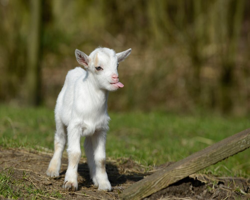

An actual Bedlington_terrier:


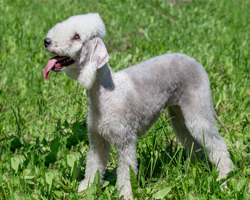

In [29]:
# Display image from tweet_id 848212111729840128
url = 'https://pbs.twimg.com/media/C8V0aI5V0AAgO9m.jpg'
with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

print('Image from tweet:')
display(img.resize((250, 200)))

# Google search result for Bedlington_terrier
url = 'https://www.bil-jac.com/media/1wkp5zs4/bedlington-terrier-1166759480.jpg'

with urllib.request.urlopen(url) as url:
    img = Image.open(BytesIO(url.read()))

print('An actual Bedlington_terrier:')
display(img.resize((250, 200)))

This might be a good goat but it is not a good dog, Brent. Although, I do understand the confusion because those tounges do make it hard to tell them apart.

<a id='predictions'></a>
### Assessing `img_predictions`

#### Visual assessment

In [30]:
img_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


There are less rows than in the `twitter_archive` which may mean that not all the tweets have images

#### Programmatic Assessment

In [31]:
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


No missing values for any of the columns

In [32]:
# Check for duplicated rows
img_predictions.duplicated().sum()

0

In [33]:
# Print out the duplicate values for each column in the data set
for col in img_predictions.columns:
    print(check_for_dupes(img_predictions, col), '\n', '--------------------------------------------', '\n')

tweet_id has 0 dupes
 
 -------------------------------------------- 

jpg_url has 66 dupes:
jpg_url
https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg    2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/CsrjryzWgAAZY00.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/media/CXrmMSpUwAAdeRj.jpg                                            1
https://pbs.twimg.com/media/CXrawAhWkAAWSxC.jpg                                            1
https://pbs.twimg.com/media/CXrIntsUsAEkv0d.jpg                                            1
https://pbs.twimg.com/media/CXqcOHCUQAAugTB.jpg               

In [34]:
# Find all the unique values in each column
for col in img_predictions.columns:
    print(f'{col.upper()} has {img_predictions[col].nunique()} unique values:\n  {img_predictions[col].sort_values().unique()} \n\n ---------------------------------------------------------\n')

TWEET_ID has 2075 unique values:
  [666020888022790149 666029285002620928 666033412701032449 ...
 891815181378084864 892177421306343426 892420643555336193] 

 ---------------------------------------------------------

JPG_URL has 2009 unique values:
  ['https://pbs.twimg.com/ext_tw_video_thumb/674805331965399040/pu/img/-7bw8niVrgIkLKOW.jpg'
 'https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg'
 'https://pbs.twimg.com/ext_tw_video_thumb/675740268751138818/pu/img/dVaVeFAVT-lk_1ZV.jpg'
 ... 'https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg'
 'https://pbs.twimg.com/tweet_video_thumb/CeGGkWuUUAAYWU1.jpg'
 'https://pbs.twimg.com/tweet_video_thumb/CtTFZZfUsAE5hgp.jpg'] 

 ---------------------------------------------------------

IMG_NUM has 4 unique values:
  [1 2 3 4] 

 ---------------------------------------------------------

P1 has 378 unique values:
  ['Afghan_hound' 'African_crocodile' 'African_grey' 'African_hunting_dog'
 'Airedale' 'Am

tweet_id values are all unique

jpg_url has duplicated values which means the same image was analyzed more than once. This will need to be investigated further.

In [35]:
# Find one of the duplicated jpg_url values
img_predictions.query('jpg_url == "https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg"')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
800,691416866452082688,https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg,1,Lakeland_terrier,0.530104,True,Irish_terrier,0.197314,True,Airedale,0.082515,True
1624,803692223237865472,https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg,1,Lakeland_terrier,0.530104,True,Irish_terrier,0.197314,True,Airedale,0.082515,True


In [36]:
# Use first tweet_id to find tweet details for duplicated jpg_url
twitter_archive.query('tweet_id == 691416866452082688')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1511,691416866452082688,NaN,NaN,2016-01-25 00:26:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I present to you... Dog Jesus. 13/10 (he could be sitting on a rock but I doubt it) https://t.co/fR1P3g5I6k,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691416866452082688/photo/1,13,10,NaN,NaN,NaN,NaN,NaN


This is an orginal tweet

In [37]:
# Use second tweet_id to find tweet details for duplicated jpg_url
twitter_archive.query('tweet_id == 803692223237865472')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
555,803692223237865472,NaN,NaN,2016-11-29 20:08:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: I present to you... Dog Jesus. 13/10 (he could be sitting on a rock but I doubt it) https://t.co/fR1P3g5I6k,6.914169e+17,4.196984e+09,2016-01-25 00:26:41 +0000,"https://twitter.com/dog_rates/status/691416866452082688/photo/1,https://twitter.com/dog_rates/status/691416866452082688/photo/1",13,10,NaN,NaN,NaN,NaN,NaN


This is a retweet and is causing the duplication.

<a id='json'></a>
### Assessing `tweet_json`

#### Visual assessment

In [38]:
tweet_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


This dataset has fewer values than the twitter_archive dataset and will need to be investigated further to understand why.

#### Programmatic Assessment

In [39]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


No missing data

In [40]:
tweet_json.duplicated().sum()

0

<a id='quality'></a>
### Quality issues


#### `twitter_archive` table
1. The name value for 55 of the tweets is 'a'
2. Not all name values are correct
3. doggo, floofer, pupper, and puppo are all NaN for most of the records
4. tweet_id is an int not a string
5. timestamp is an object not a datetime
6. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id is float and not string
7. rating_denominator has values less than and greater than 10
8. There are two more tweets than `tweet_json` table
9. There are 281 more tweets than in the `img_predictions` table
10. Missing values for in_reply_to_status_id
11. Missing values for in_reply_to_user_id
12. Missing values for retweeted_status_id
13. Missing values for retweeted_status_user_id
14. Missing values for retweeted_status_timestamp
15. Missing values for expanded_urls
16. Missing values for name
17. Ratings that are not for dogs (no image provided or image is not of a dog)
18. Replies that update ratings for original tweets but may or may add new image
19. Replies that provide ratings for other Twitter users that have posted pictures of dogs

#### `img_predictions` table
1. tweet_id is an int not a string
2. There are 281 less tweets than in the `twitter_archive` table
3. Duplicated jpg_url values

#### `tweet_json` table
1. There are two less tweets than the `twitter_archive` table

<a id='tidiness'></a>
### Tidiness issues

1. doggo, floofer, pupper, and puppo are variable names and should be combined into one column

2. The `tweet_json` table should be merged into the `twitter_archive` table because it contains information about the tweet

3. extended_urls have some values with mutliple values separated by commas and should be separated into individual columns

4. timestamp column contains day, month, year, hour, and minute variables that can be separated into individual columns

<a id='cleaning'></a>
## Cleaning Data

<ul>
<li><a href="#clean_archive">WeRateDogs Twitter archive date</a></li>
<li><a href="#clean_predictions">Image predictions data</a></li>
<li><a href="#clean_json">Twitter API data</a></li>
</ul>

In [41]:
# Make copies of original pieces of data
twitter_archive_clean = twitter_archive.copy()
img_predictions_clean = img_predictions.copy()
tweet_json_clean = tweet_json.copy()

<a id='clean_archive'></a>
### WeRateDogs Twitter archive data

<ul>
    <li><a href="#archive_issue1">Incorrect data types</a></li>
    <li><a href="#archive_issue2">Missing data</a></li>
    <li><a href="#archive_issue3">Incorrect names</a></li>
    <li><a href="#archive_issue4">Denominator values less than or greater than 10</a></li>
    <li><a href="#archive_issue5">Unneccessary columns</a></li>
</ul>

<a id='archive_issue1'></a>
#### Issue #1: Incorrect data types

##### Define: 
- Convert tweet_id values to string type using to_string()
- Convert timestamp and retweeted_status_timestamp values to datetime using to_datetime()
- Convert in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, and retweeted_status_user_id to string type
  - Store non-NaN values in new dataframes
  - Convert float to int64 to get all digits
  - Convert int64 to string
  - Replace string values into the twitter_archive_clean dataframe

##### Code:

In [42]:
# Change tweet_id to string
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype('str')

In [43]:
# Convert timestamp and retweeted_status_timestamp to DateTime type
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(twitter_archive_clean['retweeted_status_timestamp'])

In [44]:
# Convert in_reply and retweeted status and user id to string format

# Create dataframes to hold non-NaN values
reply_archive = twitter_archive_clean[~twitter_archive_clean['in_reply_to_status_id'].isna()].copy()
retweeted_archive = twitter_archive_clean[~twitter_archive_clean['retweeted_status_id'].isna()].copy()

# Convert reply_archive in_reply status and user id to int64 format to get all digits and then to string format
reply_archive['in_reply_to_status_id'] = reply_archive['in_reply_to_status_id'].astype('int64').astype('str')
reply_archive['in_reply_to_user_id'] = reply_archive['in_reply_to_user_id'].astype('int64').astype('str')

# Convert retweeted_archive retweeted status and user id to int64 format to get all digits and then to string format
retweeted_archive['retweeted_status_id'] = retweeted_archive['retweeted_status_id'].astype('int64').astype('str')
retweeted_archive['retweeted_status_user_id'] = retweeted_archive['retweeted_status_user_id'].astype('int64').astype('str')

# Replace converted values in twitter_archive_clean dataframe
twitter_archive_clean['in_reply_to_status_id'] = reply_archive['in_reply_to_status_id']
twitter_archive_clean['in_reply_to_user_id'] = reply_archive['in_reply_to_user_id']
twitter_archive_clean['retweeted_status_id'] = retweeted_archive['retweeted_status_id']
twitter_archive_clean['retweeted_status_user_id'] = retweeted_archive['retweeted_status_user_id']

##### Test:

In [45]:
# Confirm datatypes have been changed
# tweet_id should be string
# timestamp and retweeted_status_timestamp should be datetime
# in_reply_to_status_id and in_reply_to_user_id should be string
# retweeted_status_id and retweeted_status_user_id should be string

twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     object             
 2   in_reply_to_user_id         78 non-null     object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    object             
 7   retweeted_status_user_id    181 non-null    object             
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [46]:
# Confirm all in_reply_to_status_id and in_reply_to_user_id are no longer floats and all digits can be seen

twitter_archive_clean[~twitter_archive_clean['in_reply_to_status_id'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,886266357075128320,2281181600,2017-07-15 16:51:35+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaT,NaN,12,10,NaN,NaN,NaN,NaN,NaN
55,881633300179243008,881607037314052096,47384430,2017-07-02 21:58:53+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaT,NaN,17,10,NaN,NaN,NaN,NaN,NaN
64,879674319642796034,879553827334172672,3105440746,2017-06-27 12:14:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaT,NaN,14,10,NaN,NaN,NaN,NaN,NaN
113,870726314365509632,870726202742493184,16487760,2017-06-02 19:38:25+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaT,NaN,10,10,NaN,NaN,NaN,NaN,NaN
148,863427515083354112,863425645568774144,77596200,2017-05-13 16:15:35+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaT,NaN,12,10,NaN,NaN,NaN,NaN,NaN
149,863079547188785154,667152164079423488,4196983835,2017-05-12 17:12:53+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaT,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,NaN,NaN,NaN,NaN,NaN
179,857214891891077121,857156678055342080,180670967,2017-04-26 12:48:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaT,NaN,12,10,NaN,NaN,NaN,NaN,NaN
184,856526610513747968,855818117272018944,4196983835,2017-04-24 15:13:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaT,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,NaN,NaN,NaN,NaN,NaN
186,856288084350160898,856286004109553664,279280991,2017-04-23 23:26:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaT,NaN,14,10,NaN,NaN,NaN,NaN,NaN
188,855862651834028034,855861584463351808,194351775,2017-04-22 19:15:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaT,NaN,420,10,NaN,NaN,NaN,NaN,NaN


In [47]:
# Confirm all retweeted_status_id and in_reply_to_user_id are no longer floats and all digits can be seen

twitter_archive_clean[~twitter_archive_clean['retweeted_status_id'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,887473957103951872,4196983835,2017-07-19 00:47:34+00:00,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,NaN,NaN,NaN,NaN
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,886053734421102592,19607400,2017-07-15 02:44:07+00:00,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,NaN,NaN,NaN,NaN,NaN
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,830583320585068544,4196983835,2017-02-12 01:04:29+00:00,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,NaN,NaN,NaN,NaN
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,878057613040115712,4196983835,2017-06-23 01:10:23+00:00,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,NaN,NaN,NaN,NaN
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",878281511006478336,4196983835,2017-06-23 16:00:04+00:00,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,NaN,NaN,NaN,NaN
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,669000397445533696,4196983835,2015-11-24 03:51:38+00:00,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,NaN,NaN,NaN,NaN
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,876850772322988032,512804507,2017-06-19 17:14:49+00:00,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,NaN,NaN,NaN,pupper,NaN
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""

<a id='archive_issue2'></a>
#### Issue #2: Missing Data

##### Define: 
- Missing values in the name column
- Missing values in the in_reply_to_status_id and the in_reply_to_user_id columns
- Missing values in the retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns
- Missing values for entire records for all the columns: doggo, floofer, pupper, and puppo
- Missing values for expanded_urls column

> If the name of the dog is not given in the tweet, then this will have to remain a missing value
>
> Missing values for reply tweets means it is either an original tweet or a retweet so this explains why the values are missing for these two columns. Replies may or may not have images, they may or may not be updating the original rating correctly so therefore replies will be removed from this dataset and therefore these columns will also be removed.
>
> Missing values for the retweeted tweets means it is either an original tweet or a reply so this explains why the values are missing for these three columns. Retweets are duplications of original tweets and will be removed from this dataset and therefore these columns will also be removed.
>
> If the dog stage is not stated in the tweet then none of these columns would be filled in. Based on the "Dogtionary" from the #WeRateDogs book any dog is a floofer. However, that label is given to dogs with seemingly excess fur. To continue in the spirit of the floofer dog stage, I will not be adding this to dogs without a dog stage given. While I could go through each image and give a dog stage this would take too much time so these will remain as missing values.
>
> Missing values for the expanded_urls columns will be handled because this would indicate that there is no picture of a dog and therefore not something I want to include in this analysis.

##### Code:

In [48]:
# Save retweets in a new dataframe for future investigation if needed
retweets_clean = twitter_archive_clean[~twitter_archive_clean['retweeted_status_id'].isna()].copy()

# Since retweets are not replies, I will remove the columns that apply to replies
retweets_clean = retweets_clean[['tweet_id', 
                      # 'in_reply_to_status_id', 'in_reply_to_user_id', 
                      'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 
                      'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 
                      'name', 'doggo', 'floofer', 'pupper', 'puppo']].copy()

In [49]:
# Save replies in a new dataframe for future investigation if needed
replies_clean = twitter_archive_clean[~twitter_archive_clean['in_reply_to_status_id'].isna()].copy()

# Since replies are not retweets, I will remove the columns that apply to retweets
replies_clean = replies_clean[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 
                   'source', 'text', 
                   #'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
                   'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 
                   'floofer', 'pupper', 'puppo']].copy()

In [50]:
# Remove retweets from twitter_archive_clean
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isna()].copy()

In [51]:
# Remove replies from twitter_archive_clean
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['in_reply_to_status_id'].isna()].copy()

In [52]:
# Remove columns related to replies and retweets from twitter_archive_clean
twitter_archive_clean = twitter_archive_clean[['tweet_id', 
                                               #'in_reply_to_status_id', 'in_reply_to_user_id', 
                                               'timestamp', 'source', 'text', 
                                               #'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 
                                               'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 
                                               'doggo', 'floofer', 'pupper', 'puppo']].copy()

In [53]:
# Check on records without expanded_urls values
twitter_archive_clean[twitter_archive_clean['expanded_urls'].isna()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,2017-02-05 21:56:51+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,12,10,NaN,NaN,NaN,NaN,NaN
707,785515384317313025,2016-10-10 16:20:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,10,10,NaN,NaN,NaN,NaN,NaN
1445,696518437233913856,2016-02-08 02:18:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,10,10,NaN,NaN,NaN,pupper,NaN


None of these tweets have images and do not qualify to stay in this dataset.

In [54]:
# Remove tweets without images (based on the expanded_urls column)
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['expanded_urls'].isna()].copy()

##### Test:

In [55]:
retweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, 19 to 2260
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    181 non-null    object             
 1   timestamp                   181 non-null    datetime64[ns, UTC]
 2   source                      181 non-null    object             
 3   text                        181 non-null    object             
 4   retweeted_status_id         181 non-null    object             
 5   retweeted_status_user_id    181 non-null    object             
 6   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 7   expanded_urls               180 non-null    object             
 8   rating_numerator            181 non-null    int64              
 9   rating_denominator          181 non-null    int64              
 10  name                        116 non-null    object             
 

In [56]:
replies_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 30 to 2298
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               78 non-null     object             
 1   in_reply_to_status_id  78 non-null     object             
 2   in_reply_to_user_id    78 non-null     object             
 3   timestamp              78 non-null     datetime64[ns, UTC]
 4   source                 78 non-null     object             
 5   text                   78 non-null     object             
 6   expanded_urls          23 non-null     object             
 7   rating_numerator       78 non-null     int64              
 8   rating_denominator     78 non-null     int64              
 9   name                   1 non-null      object             
 10  doggo                  4 non-null      object             
 11  floofer                0 non-null      object             
 12

In [57]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2094 non-null   object             
 1   timestamp           2094 non-null   datetime64[ns, UTC]
 2   source              2094 non-null   object             
 3   text                2094 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2094 non-null   int64              
 6   rating_denominator  2094 non-null   int64              
 7   name                1494 non-null   object             
 8   doggo               83 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              229 non-null    object             
 11  puppo               24 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), ob

<a id='archive_issue3'></a>
#### Issue #3: Incorrect names

##### Define: 
- Save incorrect name values into an array
- Replace each incorrect name value as NaN using a nested dictionary and use pd.replace()

##### Code:

In [58]:
# Find incorrect name values
twitter_archive_clean['name'].sort_values(ascending=False).unique()

array(['very', 'unacceptable', 'this', 'the', 'such', 'space', 'quite',
       'one', 'old', 'officially', 'not', 'my', 'mad', 'light', 'life',
       'just', 'infuriating', 'incredibly', 'his', 'getting', 'by', 'an',
       'all', 'actually', 'a', 'Zuzu', 'Zooey', 'Zoey', 'Zoe', 'Ziva',
       'Zeus', 'Zeke', 'Zeek', 'Zara', 'Yukon', 'Yogi', 'Yoda', 'Wyatt',
       'Wishes', 'Winston', 'Winnie', 'Winifred', 'Wilson', 'Willy',
       'Willow', 'Willie', 'William', 'Willem', 'Wiggles', 'Wesley',
       'Watson', 'Walter', 'Wally', 'Wallace', 'Walker', 'Waffles',
       'Wafer', 'Vixen', 'Vinscent', 'Vinnie', 'Vincent', 'Vince',
       'Venti', 'Ulysses', 'Tyrus', 'Tyrone', 'Tyr', 'Tycho', 'Tupawc',
       'Tug', 'Tuco', 'Tucker', 'Tuck', 'Trooper', 'Tripp', 'Trip',
       'Trigger', 'Trevith', 'Traviss', 'Travis', 'Tove', 'Torque',
       'Tonks', 'Tommy', 'Tom', 'Toffee', 'Todo', 'Toby', 'Tobi', 'Tito',
       'Titan', 'Tino', 'Timofy', 'Timmy', 'Timison', 'Timber', 'Tilly',
       'Ti

In [59]:
# Save incorrect names to array
incorrect_names = ['very', 'unacceptable', 'this', 'the', 'such', 'space', 'quite', 
                   'one', 'old', 'officially', 'not', 'my', 'mad', 'light', 'life', 
                   'just', 'infuriating', 'incredibly', 'his', 'getting', 'by', 'an', 
                   'all', 'actually', 'a']

# Create nested dictionary to use with pandas replace()
my_dict = {} # Create empty dictionary
my_dict['name'] = {} # Create a nested dictionary
for incorrect_name in incorrect_names:
    my_dict['name'][incorrect_name] = np.nan # Add each incorrect name to the nested dictionary with NaN as the value

# For a DataFrame nested dictionaries, e.g., {'name': {'incorrect_name': np.nan}}, are read as follows: 
# look in column ‘name’ for the value ‘incorrect_name’ and replace it with NaN. 
# The optional value parameter should not be specified to use a nested dict in this way.
twitter_archive_clean = twitter_archive_clean.replace(to_replace=my_dict).copy()

##### Test:

In [60]:
twitter_archive_clean['name'].sort_values(ascending=False).unique()

array(['Zuzu', 'Zooey', 'Zoey', 'Zoe', 'Ziva', 'Zeus', 'Zeke', 'Zeek',
       'Zara', 'Yukon', 'Yogi', 'Yoda', 'Wyatt', 'Wishes', 'Winston',
       'Winnie', 'Winifred', 'Wilson', 'Willy', 'Willow', 'Willie',
       'William', 'Willem', 'Wiggles', 'Wesley', 'Watson', 'Walter',
       'Wally', 'Wallace', 'Walker', 'Waffles', 'Wafer', 'Vixen',
       'Vinscent', 'Vinnie', 'Vincent', 'Vince', 'Venti', 'Ulysses',
       'Tyrus', 'Tyrone', 'Tyr', 'Tycho', 'Tupawc', 'Tug', 'Tuco',
       'Tucker', 'Tuck', 'Trooper', 'Tripp', 'Trip', 'Trigger', 'Trevith',
       'Traviss', 'Travis', 'Tove', 'Torque', 'Tonks', 'Tommy', 'Tom',
       'Toffee', 'Todo', 'Toby', 'Tobi', 'Tito', 'Titan', 'Tino',
       'Timofy', 'Timmy', 'Timison', 'Timber', 'Tilly', 'Tiger', 'Thumas',
       'Thor', 'Theodore', 'Theo', 'Tess', 'Terry', 'Terrenth',
       'Terrance', 'Tedrick', 'Teddy', 'Tedders', 'Ted', 'Tebow', 'Taz',
       'Tayzie', 'Tater', 'Tassy', 'Tanner', 'Tango', 'Taco', 'Sweets',
       'Sweet', 'Swagger

<a id='archive_issue4'></a>
#### Issue #4: Numerator and Denominator values

##### Define: 
- Remove or replace denominator values not equal to 10
- Remove or replace numerator values that are considered outliers

##### Code:

In [61]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

In [62]:
# Find denominator lower than 10
twitter_archive_clean.query('rating_denominator < 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
516,810984652412424192,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,NaN,NaN,NaN,NaN
2335,666287406224695296,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,NaN,NaN,NaN,NaN,NaN


In [63]:
# tweet_id 810984652412424192 does not actually have a rating and should be removed from dataset
twitter_archive_clean = twitter_archive_clean.query('tweet_id != "810984652412424192"') \
                                             .reset_index(drop=True) \
                                             .copy()

In [64]:
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == '666287406224695296'].index

Index([2072], dtype='int64')

In [65]:
# Fix incorrect ratings for numerator and denominator from 1 and 2, should be 9 and 10
twitter_archive_clean.loc[2072, ['rating_numerator', 'rating_denominator']] = [9, 10]

In [66]:
# Find denominator higher than 10
twitter_archive_clean.query('rating_denominator > 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
338,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,NaN,NaN,NaN,NaN,NaN
697,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,NaN,NaN,NaN,NaN,NaN
850,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,NaN,NaN,NaN,NaN,NaN
901,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,NaN,NaN,NaN,NaN,NaN
945,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,NaN,NaN,NaN,NaN,NaN
982,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN,NaN,NaN,NaN
1008,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,NaN,NaN,NaN,NaN,NaN
1033,710658690886586372,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,NaN,NaN,NaN,NaN,NaN
1053,709198395643068416,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,NaN,NaN,NaN,NaN,NaN
1126,704054845121142784,2016-02-28 21:25:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60,50,NaN,NaN,NaN,NaN,NaN


I noticed that one of the tweets does not have an image and instead there is a video. This is another data quality issue since we only want ratings for original tweets with images. I will go ahead and handle the cleanup process for this here and remove tweets with videos or that include a link to a vine video.

In [67]:
# Find tweets that give ratings for videos since we only want ratings for images
# Create a new dataframe for all tweets that include videos for future investigation if needed
video_tweets = twitter_archive_clean[twitter_archive_clean['expanded_urls'].str.contains('video|vine', case=False)].copy()

# Confirm new dataframe
video_tweets

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
15,889278841981685760,2017-07-24 00:19:32+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Oliver. You're witnessing one of his many brutal attacks. Seems to be playing with his victim. 13/10 fr*ckin frightening #BarkWeek https://t.co/WpHvrQedPb,https://twitter.com/dog_rates/status/889278841981685760/video/1,13,10,Oliver,NaN,NaN,NaN,NaN
21,887517139158093824,2017-07-19 03:39:09+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,NaN,NaN,NaN,NaN,NaN
23,887343217045368832,2017-07-18 16:08:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,https://twitter.com/dog_rates/status/887343217045368832/video/1,13,10,NaN,NaN,NaN,NaN,NaN
51,881536004380872706,2017-07-02 15:32:16+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,NaN,NaN,NaN,pupper,NaN
60,879415818425184262,2017-06-26 19:07:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,https://twitter.com/dog_rates/status/879415818425184262/video/1,13,10,Duddles,NaN,NaN,NaN,NaN
77,875144289856114688,2017-06-15 00:13:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Nugget and Hank. Nugget took Hank's bone. Hank is wondering if you would please return it to him. Both 13/10 would not intervene https://t.co/ogith9ejNj,https://twitter.com/dog_rates/status/875144289856114688/video/1,13,10,Nugget,NaN,NaN,NaN,NaN
124,863553081350529029,2017-05-14 00:34:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Neptune. He's a backpup vocalist for the Dixie Chicks. 13/10 (vid by @AmiWinehouse) https://t.co/tordvmaaop,https://twitter.com/dog_rates/status/863553081350529029/video/1,13,10,Neptune,NaN,NaN,NaN,NaN
132,861288531465048066,2017-05-07 18:36:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",HI. MY. NAME. IS. BOOMER. AND. I. WANT. TO. SAY. IT'S. H*CKIN. RIDICULOUS. THAT. DOGS. CAN'T VOTE. ABSOLUTE. CODSWALLUP. THANK. YOU. 13/10 https://t.co/SqKJPwbQ2g,https://twitter.com/dog_rates/status/861288531465048066/video/1,13,10,NaN,NaN,NaN,NaN,NaN
141,859196978902773760,2017-05-02 00:04:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,NaN,NaN,NaN,NaN,NaN
169,852226086759018497,2017-04-12 18:25:07+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","Meet General. He wasn't content with the quality of his room. Requested to pupgrade, but was ignored. 14/10 look who just lost a customer https://t.co/NP5JW8LnmW",https://twitter.com/dog_rates/status/852226086759018497/video/1,14,10,General,NaN,NaN,NaN,NaN


In [68]:
# Remove tweets that have video from the twitter_archive_clean dataset
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['expanded_urls'].str.contains('video|vine', case=False)] \
                                                                .reset_index(drop=True) \
                                                                .copy()

# Confirm video tweets have been removed
twitter_archive_clean[twitter_archive_clean['expanded_urls'].str.contains('video|vine', case=False)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [69]:
# Find denominator higher than 10 now that video tweets have been removed
twitter_archive_clean.query('rating_denominator > 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
322,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,NaN,NaN,NaN,NaN,NaN
773,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,NaN,NaN,NaN,NaN,NaN
819,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,NaN,NaN,NaN,NaN,NaN
862,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,NaN,NaN,NaN,NaN,NaN
897,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN,NaN,NaN,NaN
918,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,NaN,NaN,NaN,NaN,NaN
943,710658690886586372,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,NaN,NaN,NaN,NaN,NaN
961,709198395643068416,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,NaN,NaN,NaN,NaN,NaN
1024,704054845121142784,2016-02-28 21:25:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60,50,NaN,NaN,NaN,NaN,NaN
1096,697463031882764288,2016-02-10 16:51:59+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44,40,NaN,NaN,NaN,NaN,NaN


In [70]:
# tweet_id: 820690176645140481 - Litter of seven puppies - adjust numerator and denominator for this 82/70 --> 12/10
twitter_archive_clean.loc[322, ['rating_numerator', 'rating_denominator']] = [12, 10]
# tweet_id: 740373189193256964 - rating was 9/11 should be 14/10
twitter_archive_clean.loc[773, ['rating_numerator', 'rating_denominator']] = [14, 10]
# tweet_id: 731156023742988288 - rating was 204/170 and after adjusting based on number of dogs should be 12/10
twitter_archive_clean.loc[819, ['rating_numerator', 'rating_denominator']] = [12, 10]
# tweet_id: 722974582966214656 - rating was 4/20 and should be 13/10
twitter_archive_clean.loc[862, ['rating_numerator', 'rating_denominator']] = [13, 10]
# tweet_id: 716439118184652801 - rating was 50/50 and should be 9/10
twitter_archive_clean.loc[897, ['rating_numerator', 'rating_denominator']] = [9, 10]
# tweet_id: 713900603437621249 - rating was 99/90 and should be 11/10
twitter_archive_clean.loc[918, ['rating_numerator', 'rating_denominator']] = [11, 10]
# tweet_id: 710658690886586372 - rating was 80/80 and should be 10/10
twitter_archive_clean.loc[943, ['rating_numerator', 'rating_denominator']] = [10, 10]
# tweet_id: 709198395643068416 - rating was 45/50 and should be 9/10
twitter_archive_clean.loc[961, ['rating_numerator', 'rating_denominator']] = [9, 10]
# tweet_id: 704054845121142784 - rating was 60/50 and should be 12/10
twitter_archive_clean.loc[1024, ['rating_numerator', 'rating_denominator']] = [12, 10]
# tweet_id: 697463031882764288 - rating was 44/40 and should be 11/10
twitter_archive_clean.loc[1096, ['rating_numerator', 'rating_denominator']] = [11, 10]
# tweet_id: 684222868335505415 - rating was 121/110 and should be 11/10
twitter_archive_clean.loc[1257, ['rating_numerator', 'rating_denominator']] = [11, 10]
# tweet_id: 682962037429899265 - rating was 7/11 and should be 10/10
twitter_archive_clean.loc[1281, ['rating_numerator', 'rating_denominator']] = [10, 10]
# tweet_id: 677716515794329600 - rating was 144/120 and should be 12/10
twitter_archive_clean.loc[1385, ['rating_numerator', 'rating_denominator']] = [12, 10]
# tweet_id: 675853064436391936 - rating was 88/80 and should be 11/10
twitter_archive_clean.loc[1440, ['rating_numerator', 'rating_denominator']] = [11, 10]

In [71]:
# confirm no tweets with rating_denominator not equal to 10 exists
twitter_archive_clean.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [78]:
twitter_archive_clean['rating_numerator'].value_counts()

rating_numerator
12      437
10      417
11      388
13      245
9       150
8        93
7        51
5        33
14       32
6        32
3        19
4        14
2         9
1         4
27        1
75        1
0         1
1776      1
26        1
420       1
Name: count, dtype: int64

In [79]:
twitter_archive_clean.query('rating_numerator > 14')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
496,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,NaN,NaN,NaN,NaN
545,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,NaN,NaN,pupper,NaN
705,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,NaN,NaN,NaN,NaN
1327,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,NaN,NaN,NaN,NaN,NaN
1655,670842764863651840,2015-11-29 05:52:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420,10,NaN,NaN,NaN,NaN,NaN


In [80]:
# tweet_id 670842764863651840 is a rating for Snoop Dogg and should be removed
twitter_archive_clean = twitter_archive_clean.query('tweet_id != "670842764863651840"') \
                                             .reset_index(drop=True) \
                                             .copy()

In [82]:
# Ensure there are only 4 results after removing the rating for Snoop Dogg
twitter_archive_clean.query('rating_numerator > 14')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
496,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,NaN,NaN,NaN,NaN
545,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,NaN,NaN,pupper,NaN
705,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,NaN,NaN,NaN,NaN
1327,680494726643068929,2015-12-25 21:06:00+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,NaN,NaN,NaN,NaN,NaN


> For the ratings that are given as decimals in the tweet, I will be rounding these values to the nearest whole number because they really are good bois, brent and deserve it!
>
> For Atticus with the 1776 rating, I have decided to keep this tweet but to adjust the rating to the highest rating given which is 14/10.

In [85]:
# tweet_id: 786709082849828864 - adjust numerator from 9.75/10 to 10/10
twitter_archive_clean.loc[496, ['rating_numerator', 'rating_denominator']] = [10, 10]
# tweet_id: 778027034220126208 - rating was 11.27/10 and will now be 12/10
twitter_archive_clean.loc[545, ['rating_numerator', 'rating_denominator']] = [12, 10]
# tweet_id: 749981277374128128 - rating was 1776/10 will now be 14/10
twitter_archive_clean.loc[705, ['rating_numerator', 'rating_denominator']] = [14, 10]
# tweet_id: 680494726643068929 - rating was 11.26/10 and should be 12/10
twitter_archive_clean.loc[1327, ['rating_numerator', 'rating_denominator']] = [12, 10]

In [87]:
twitter_archive_clean['rating_numerator'].value_counts()

rating_numerator
12    439
10    418
11    388
13    245
9     150
8      93
7      51
14     33
5      33
6      32
3      19
4      14
2       9
1       4
0       1
Name: count, dtype: int64

In [90]:
twitter_archive_clean.query('rating_numerator == 0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
234,835152434251116546,2017-02-24 15:40:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,NaN,NaN,NaN,NaN,NaN


In [91]:
# tweet_id 835152434251116546 was complaining about plagiarism, needs to be removed
twitter_archive_clean = twitter_archive_clean.query('rating_numerator != 0') \
                                             .reset_index(drop=True) \
                                             .copy()

In [92]:
twitter_archive_clean['rating_numerator'].value_counts()

rating_numerator
12    439
10    418
11    388
13    245
9     150
8      93
7      51
14     33
5      33
6      32
3      19
4      14
2       9
1       4
Name: count, dtype: int64

In [93]:
twitter_archive_clean.query('rating_numerator == 1')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1460,675153376133427200,2015-12-11 03:21:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",What kind of person sends in a picture without a dog in it? 1/10 just because that's a nice table https://t.co/RDXCfk8hK0,https://twitter.com/dog_rates/status/675153376133427200/photo/1,1,10,NaN,NaN,NaN,NaN,NaN
1670,670783437142401025,2015-11-29 01:56:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Flamboyant pup here. Probably poisonous. Won't eat kibble. Doesn't bark. Slow af. Petting doesn't look fun. 1/10 https://t.co/jxukeh2BeO,https://twitter.com/dog_rates/status/670783437142401025/photo/1,1,10,NaN,NaN,NaN,NaN,NaN
1834,667549055577362432,2015-11-20 03:44:31+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Never seen dog like this. Breathes heavy. Tilts head in a pattern. No bark. Shitty at fetch. Not even cordless. 1/10 https://t.co/i9iSGNn3fx,https://twitter.com/dog_rates/status/667549055577362432/photo/1,1,10,NaN,NaN,NaN,NaN,NaN
1910,666104133288665088,2015-11-16 04:02:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX,https://twitter.com/dog_rates/status/666104133288665088/photo/1,1,10,NaN,NaN,NaN,NaN,NaN


In [94]:
# tweet_id 670783437142401025 is not a picture of a pup, needs to be removed
# tweet_id 667549055577362432 is not a picture of a dog, needs to be removed
# tweet_id 666104133288665088 is not a picture of a dog, needs to be removed
twitter_archive_clean = twitter_archive_clean.query(
    '(tweet_id != "670783437142401025") & (tweet_id != "667549055577362432") & (tweet_id != "666104133288665088")'
).reset_index(drop=True).copy()

In [95]:
twitter_archive_clean['rating_numerator'].value_counts()

rating_numerator
12    439
10    418
11    388
13    245
9     150
8      93
7      51
14     33
5      33
6      32
3      19
4      14
2       9
1       1
Name: count, dtype: int64

In [96]:
twitter_archive_clean.query('rating_numerator == 2')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1369,678675843183484930,2015-12-20 20:38:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Exotic pup here. Tail long af. Throat looks swollen. Might breathe fire. Exceptionally unfluffy 2/10 would still pet https://t.co/a8SqCaSo2r,https://twitter.com/dog_rates/status/678675843183484930/photo/1,2,10,NaN,NaN,NaN,NaN,NaN
1372,678424312106393600,2015-12-20 03:58:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible https://t.co/rtMtjSl9pz,https://twitter.com/dog_rates/status/678424312106393600/photo/1,2,10,Crystal,NaN,NaN,NaN,NaN
1503,674265582246694913,2015-12-08 16:33:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Henry. He's a shit dog. Short pointy ears. Leaves trail of pee. Not fluffy. Doesn't come when called. 2/10 https://t.co/Pu9RhfHDEQ,https://twitter.com/dog_rates/status/674265582246694913/photo/1,2,10,Henry,NaN,NaN,NaN,NaN
1658,670826280409919488,2015-11-29 04:47:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Scary dog here. Too many legs. Extra tail. Not soft, let alone fluffy. Won't bark. Moves sideways. Has weapon. 2/10 https://t.co/XOPXCSXiUT",https://twitter.com/dog_rates/status/670826280409919488/photo/1,2,10,NaN,NaN,NaN,NaN,NaN
1811,668142349051129856,2015-11-21 19:02:04+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This lil pup is Oliver. Hops around. Has wings but doesn't fly (lame). Annoying chirp. Won't catch tennis balls 2/10 https://t.co/DnhUw0aBM2,https://twitter.com/dog_rates/status/668142349051129856/photo/1,2,10,NaN,NaN,NaN,NaN,NaN
1820,667878741721415682,2015-11-21 01:34:35+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;2/10 https://t.co/LvP1TTYSCN,https://twitter.com/dog_rates/status/667878741721415682/photo/1,2,10,Tedrick,NaN,NaN,NaN,NaN
1880,666786068205871104,2015-11-18 01:12:41+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Unfamiliar with this breed. Ears pointy af. Won't let go of seashell. Won't eat kibble. Not very fast. Bad dog 2/10 https://t.co/EIn5kElY1S,https://twitter.com/dog_rates/status/666786068205871104/photo/1,2,10,NaN,NaN,NaN,NaN,NaN
1896,666411507551481857,2015-11-17 00:24:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is quite the dog. Gets really excited when not in water. Not very soft tho. Bad at fetch. Can't do tricks. 2/10 https://t.co/aMCTNWO94t,https://twitter.com/dog_rates/status/666411507551481857/photo/1,2,10,NaN,NaN,NaN,NaN,NaN
1918,666051853826850816,2015-11-16 00:35:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,NaN,NaN,NaN,NaN,NaN


In [97]:
# tweet_id 667878741721415682 is a picture of a dog with a rating of 10&2/10 so we will make this 12/10
twitter_archive_clean.loc[1820, ['rating_numerator', 'rating_denominator']] = [12, 10]

In [99]:
# tweet_id 678675843183484930, 674265582246694913, 670826280409919488, 668142349051129856, 666786068205871104, 666411507551481857, 666051853826850816 is not a picture of a dog, needs to be removed
twitter_archive_clean = twitter_archive_clean.query(
    '(tweet_id != "678675843183484930") & (tweet_id != "674265582246694913") & (tweet_id != "670826280409919488") & \
     (tweet_id != "668142349051129856") & (tweet_id != "666786068205871104") & (tweet_id != "666411507551481857") & \
     (tweet_id != "666051853826850816")'
).reset_index(drop=True).copy()

In [100]:
twitter_archive_clean['rating_numerator'].value_counts()

rating_numerator
12    440
10    418
11    388
13    245
9     150
8      93
7      51
14     33
5      33
6      32
3      19
4      14
2       1
1       1
Name: count, dtype: int64

> While more cleanup for the ratings with numerators could continue, I am stopping the process here since it is very manual work to get through and look at all the images for now.

##### Test:

In [103]:
# Check for values of the rating_denominator, should only be one value: 10
twitter_archive_clean['rating_denominator'].value_counts()

rating_denominator
10    1918
Name: count, dtype: int64

In [105]:
# Check the rating_numerator values after cleaning up the ratings over 14 and less than 3. 
twitter_archive_clean['rating_numerator'].value_counts()

rating_numerator
12    440
10    418
11    388
13    245
9     150
8      93
7      51
14     33
5      33
6      32
3      19
4      14
2       1
1       1
Name: count, dtype: int64

In [101]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1918 non-null   object             
 1   timestamp           1918 non-null   datetime64[ns, UTC]
 2   source              1918 non-null   object             
 3   text                1918 non-null   object             
 4   expanded_urls       1918 non-null   object             
 5   rating_numerator    1918 non-null   int64              
 6   rating_denominator  1918 non-null   int64              
 7   name                1315 non-null   object             
 8   doggo               67 non-null     object             
 9   floofer             7 non-null      object             
 10  pupper              202 non-null    object             
 11  puppo               23 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2

<a id='archive_issue5'></a>
#### Issue #5: Unneccessary columns

##### Define
- Remove source column
- Remove expanded_urls

##### Code

In [108]:
twitter_archive_clean = twitter_archive_clean[['tweet_id', 'timestamp', 
                                                #'source', 
                                                'text', 
                                                #'expanded_urls', 
                                                'rating_numerator', 'rating_denominator', 'name', 
                                                'doggo', 'floofer', 'pupper', 'puppo']].copy()

##### Test

In [109]:
twitter_archive_clean.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1667,670782429121134593,2015-11-29 01:52:48+00:00,This dude slaps your girl's ass what do you do?\n5/10 https://t.co/6dioUL6gcP,5,10,NaN,NaN,NaN,NaN,NaN
1798,668268907921326080,2015-11-22 03:24:58+00:00,Here we have an Azerbaijani Buttermilk named Guss. He sees a demon baby Hitler behind his owner. 10/10 stays alert https://t.co/aeZykWwiJN,10,10,NaN,NaN,NaN,NaN,NaN
837,727685679342333952,2016-05-04 02:26:00+00:00,This is Cilantro. She's a Fellation Gadzooks. Eyes are super magical af. 12/10 could get lost in https://t.co/yJ26LNuyj5,12,10,Cilantro,NaN,NaN,NaN,NaN
257,831670449226514432,2017-02-15 01:04:21+00:00,This is Daisy. She has a heart on her butt. 13/10 topical af https://t.co/u6p4LxzHKg,13,10,Daisy,NaN,NaN,NaN,NaN
1728,669625907762618368,2015-11-25 21:17:12+00:00,This is Penny. She's having fun AND being safe. 12/10 very responsible pup https://t.co/eqeWw67oU7,12,10,Penny,NaN,NaN,NaN,NaN
1679,670668383499735048,2015-11-28 18:19:37+00:00,This is Phineas. He's a magical dog. Only appears through the hole of a donut. 10/10 mysterious pup https://t.co/NECxEHN5YU,10,10,Phineas,NaN,NaN,NaN,NaN
954,709556954897764353,2016-03-15 01:48:55+00:00,This is Cecil. She's a Gigglefloof Poofer. Outdoorsy af. One with nature. 12/10 would strategically capture https://t.co/ijJB0DuOIC,12,10,Cecil,NaN,NaN,NaN,NaN
1217,687096057537363968,2016-01-13 02:17:20+00:00,This pupper's New Year's resolution was to become a Hershey's kiss. 11/10 she's super pumped about it https://t.co/D7jYj6vdwC,11,10,NaN,NaN,NaN,pupper,NaN
1737,669375718304980992,2015-11-25 04:43:02+00:00,This is Billl. He's trying to be a ghost but he's not very good at it. 6/10 c'mon Billl https://t.co/ero0XfdGtY,6,10,Billl,NaN,NaN,NaN,NaN
614,765222098633691136,2016-08-15 16:22:20+00:00,This is Gromit. He's pupset because there's no need to beware of him. Just wants a pettin. 10/10 https://t.co/eSvz4EapHH,10,10,Gromit,NaN,NaN,NaN,NaN


<a id='clean_predictions'></a>
### Image predictions data

<a id='clean_json'></a>
### Twitter API data

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

<a id='eda'></a>
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1.

2.

3.

### Visualization

<a id='conclusions'></a>
## Conclusions

<a id='resources'></a>
## Resources

[Blog post](https://saturncloud.io/blog/how-to-show-images-in-jupyter-notebook/) by Saturn Cloud for showing images in Jupyter Notebook

[Pillow documentation](https://pillow.readthedocs.io/en/stable/reference/Image.html#functions) for displaying images